In [1]:
# === CELL 1: Imports & config ===
import os, math, pathlib, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix

# Allmän setup
SEED = 42
tf.keras.utils.set_random_seed(SEED)

# (Valfritt) snällare GPU-minne
for g in tf.config.list_physical_devices("GPU"):
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# Sökvägar
DATA_DIR = pathlib.Path("images1")
TRAIN_DIR = DATA_DIR / "train"
TEST_DIR  = DATA_DIR / "test"

EXPORT_DIR = pathlib.Path("exported_models")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Bild & batch
IMG_SIZE = (300, 300)       # EfficientNetB3 rekommenderar 300x300
BATCH    = 32               # höj/sänk efter VRAM (t.ex. 32 på 12GB, 16 på 8GB)
VAL_SPLIT = 0.15            # tar 15% av train som val


In [3]:
# === CELL 2: Data loading (tf.data) ===
# Assumes TRAIN_DIR, TEST_DIR, IMG_SIZE, BATCH, VAL_SPLIT, SEED are already defined.
AUTOTUNE = tf.data.AUTOTUNE

# --- Load raw datasets (keep these before cache/prefetch to retain metadata like class_names) ---
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=VAL_SPLIT,
    subset="training",
    seed=SEED
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    validation_split=VAL_SPLIT,
    subset="validation",
    seed=SEED
)

# Note: TEST_DIR is a separate folder; do NOT use subset here.
raw_test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="binary",
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

# --- Class names must be read from a raw dataset (prefetch/cached datasets lose this attribute) ---
class_names = raw_train_ds.class_names
print("Klassordning:", class_names)  # Expected: ['benign', 'malignant']

# --- Build performant input pipelines ---
train_ds = raw_train_ds.shuffle(8 * BATCH, seed=SEED).cache().prefetch(AUTOTUNE)
val_ds   = raw_val_ds.cache().prefetch(AUTOTUNE)
test_ds  = raw_test_ds.cache().prefetch(AUTOTUNE)

# --- Count class distribution for class_weight (use raw dataset for clarity) ---
def count_labels(ds):
    """Return counts (c0, c1) for binary labels in a tf.data.Dataset."""
    c0 = c1 = 0
    for _, y in ds.unbatch():
        v = int(tf.squeeze(y).numpy())  # robust for shape () or (1,)
        if v == 0:
            c0 += 1
        else:
            c1 += 1
    return c0, c1

train_c0, train_c1 = count_labels(raw_train_ds)
print("Train counts:", train_c0, train_c1)

# --- Compute class_weight (simple inverse-frequency) ---
total = train_c0 + train_c1
w0 = total / (2.0 * train_c0) if train_c0 > 0 else 1.0
w1 = total / (2.0 * train_c1) if train_c1 > 0 else 1.0
class_weight = {0: w0, 1: w1}
print("class_weight:", class_weight)


Found 9605 files belonging to 2 classes.
Using 8165 files for training.
Found 9605 files belonging to 2 classes.
Using 1440 files for validation.
Found 1000 files belonging to 2 classes.
Klassordning: ['benign', 'malignant']
Train counts: 4257 3908
class_weight: {0: 0.9590086915668311, 1: 1.0446519959058342}


In [5]:
# === CELL: Build EfficientNetB3 model ===
# Works with both tf.keras (2.x) and keras==3.x
from tensorflow import keras as tfk  # always available with TF backend
from tensorflow.keras import layers, regularizers

try:
    # Keras 3 API (preferred import path still works with tf backend)
    from keras.applications.efficientnet import EfficientNetB3, preprocess_input
except Exception:
    # Older TF-keras fallback
    from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input

# Try to use AdamW (supports weight_decay); fallback to Adam if unavailable
try:
    from keras.optimizers import AdamW as _AdamW
    def make_optimizer(lr, wd):
        return _AdamW(learning_rate=lr, weight_decay=wd)
except Exception:
    try:
        from tensorflow.keras.optimizers import Adam as _Adam
    except Exception:
        from keras.optimizers import Adam as _Adam
    def make_optimizer(lr, wd):
        # Adam doesn't support weight_decay argument; ignore wd
        return _Adam(learning_rate=lr)

def build_efficientnet_b3(
    img_size,
    wd=4e-4,          # weight decay for AdamW (ignored if Adam fallback)
    dropout=0.30,
    lr=1e-3,
    name="transfer_efficientNetB3"
):
    """Builds an EfficientNetB3 binary classifier with on-the-fly augmentation."""
    x = layers.Input(shape=img_size + (3,), name="input")

    # --- Augmentation (GPU-friendly) ---
    a = layers.RandomFlip("horizontal")(x)
    a = layers.RandomRotation(0.10)(a)
    a = layers.RandomZoom(0.10)(a)
    a = layers.RandomContrast(0.20)(a)

    # --- EfficientNetB3 backbone ---
    a = layers.Lambda(preprocess_input, name="preproc")(a)
    base = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=a)
    base.trainable = False  # Phase 1: freeze backbone

    y = layers.GlobalAveragePooling2D(name="gap")(base.output)
    y = layers.Dropout(dropout)(y)
    y = layers.Dense(
        128, activation="relu",
        kernel_regularizer=regularizers.l2(wd)
    )(y)
    y = layers.Dense(1, activation="sigmoid", name="pred")(y)

    model = tfk.Model(inputs=x, outputs=y, name=name)

    model.compile(
        optimizer=make_optimizer(lr, wd),
        loss=tfk.losses.BinaryCrossentropy(label_smoothing=0.03),
        metrics=["accuracy", tfk.metrics.AUC(name="auc")]
    )
    return model, base

# Build once to verify
model, base = build_efficientnet_b3(IMG_SIZE)
model.summary()


Model: "transfer_efficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_1 (RandomFlip)     (None, 300, 300, 3)  0           ['input[0][0]']                  
                                                                                                  
 random_rotation_1 (RandomRotat  (None, 300, 300, 3)  0          ['random_flip_1[0][0]']          
 ion)                                                                                             
                                                                            

In [8]:
# === CELL: Train Phase 1 (frozen base) — robust checkpointing ===
import os
from tensorflow import keras as tfk
from tensorflow.keras import callbacks

# --- Ensure class_weight are plain Python floats ---
safe_class_weight = {int(k): float(v) for k, v in class_weight.items()}

# --- Paths ---
ckpt_dir = EXPORT_DIR if 'EXPORT_DIR' in globals() else "."
weights_p1 = os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1.weights.h5")
fullmodel_p1 = os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1.keras")

# --- Callbacks ---
cb_early = callbacks.EarlyStopping(
    monitor="val_auc", mode="max",
    patience=5, restore_best_weights=True, verbose=1
)
cb_rlr = callbacks.ReduceLROnPlateau(
    monitor="val_auc", mode="max",
    factor=0.5, patience=3, min_lr=1e-7, verbose=1
)
# Save only weights during training to avoid JSON serialization issues
cb_ckpt = callbacks.ModelCheckpoint(
    filepath=str(weights_p1),
    monitor="val_auc", mode="max",
    save_best_only=True,
    save_weights_only=True,   # <-- key change
    verbose=1
)

# --- Train (Phase 1: base frozen) ---
EPOCHS_P1 = 12
history_p1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=int(EPOCHS_P1),
    class_weight=safe_class_weight,
    callbacks=[cb_early, cb_rlr, cb_ckpt],
    verbose=1
)

# --- Load best weights and then save the full model once (outside callbacks) ---
model.load_weights(weights_p1)
model.save(fullmodel_p1)   # now safe; uses the already-loaded best weights
print("Saved best Phase-1 weights to:", weights_p1)
print("Saved full Phase-1 model to:", fullmodel_p1)


Epoch 1/12
256/256 [==============================] - ETA: 0s - loss: 0.3283 - accuracy: 0.9035 - auc: 0.9635
Epoch 1: val_auc improved from -inf to 0.96841, saving model to exported_models\transfer_efficientNetB3_best_p1.weights.h5
256/256 [==============================] - 194s 758ms/step - loss: 0.3283 - accuracy: 0.9035 - auc: 0.9635 - val_loss: 0.3260 - val_accuracy: 0.9042 - val_auc: 0.9684 - lr: 0.0010
Epoch 2/12
256/256 [==============================] - ETA: 0s - loss: 0.3224 - accuracy: 0.9070 - auc: 0.9640
Epoch 2: val_auc improved from 0.96841 to 0.96920, saving model to exported_models\transfer_efficientNetB3_best_p1.weights.h5
256/256 [==============================] - 196s 766ms/step - loss: 0.3224 - accuracy: 0.9070 - auc: 0.9640 - val_loss: 0.3165 - val_accuracy: 0.9049 - val_auc: 0.9692 - lr: 0.0010
Epoch 3/12
256/256 [==============================] - ETA: 0s - loss: 0.3105 - accuracy: 0.9088 - auc: 0.9666
Epoch 3: val_auc improved from 0.96920 to 0.96996, saving mod

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

In [10]:
# === CELL: Find best weights and export as SavedModel (robust) ===
import os, glob, shutil, tensorflow as tf

# Base directory where you saved checkpoints
ckpt_dir = EXPORT_DIR if 'EXPORT_DIR' in globals() else "."

# Candidate filenames (both styles)
candidates = [
    os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1.weights.h5"),  # with dot
    os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1_weights.h5"),  # with underscore
]

# Pick an existing candidate or fall back to a glob search
weights_path = next((p for p in candidates if os.path.exists(p)), None)
if weights_path is None:
    matches = glob.glob(os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1*.h5"))
    if not matches:
        raise FileNotFoundError(
            f"No weights file found in {ckpt_dir}. "
            f"Files here: {sorted(os.listdir(ckpt_dir))[:50]}"
        )
    # Prefer the ".weights.h5" style if present
    matches.sort(key=lambda s: (".weights." not in s, s))
    weights_path = matches[0]

# Output folder for SavedModel (fresh)
savedmodel_dir = os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1_savedmodel")
if os.path.isdir(savedmodel_dir):
    shutil.rmtree(savedmodel_dir)

# Load best weights and export without JSON serialization
model.load_weights(weights_path)
try:
    model.export(savedmodel_dir)           # Keras 3
except Exception:
    tf.saved_model.save(model, savedmodel_dir)  # TF-keras fallback

print("✅ Loaded weights from:", weights_path)
print("✅ Exported SavedModel to:", savedmodel_dir)


INFO:tensorflow:Assets written to: exported_models\transfer_efficientNetB3_best_p1_savedmodel\assets


INFO:tensorflow:Assets written to: exported_models\transfer_efficientNetB3_best_p1_savedmodel\assets


✅ Loaded weights from: exported_models\transfer_efficientNetB3_best_p1.weights.h5
✅ Exported SavedModel to: exported_models\transfer_efficientNetB3_best_p1_savedmodel


In [12]:
# === CELL 5: Unfreeze last ~35% (keep BatchNorm frozen) + re-compile ===
from tensorflow import keras as tfk
from tensorflow.keras import layers
try:
    from tensorflow.keras.layers import BatchNormalization
except Exception:
    from keras.layers import BatchNormalization  # fallback

# Robust optimizer factory: try AdamW (keras/tf-keras/TFA), else fallback to Adam
def make_optimizer(lr, wd):
    try:
        from tensorflow.keras.optimizers import AdamW
        return AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        try:
            from keras.optimizers import AdamW
            return AdamW(learning_rate=lr, weight_decay=wd)
        except Exception:
            try:
                from tensorflow_addons.optimizers import AdamW
                return AdamW(learning_rate=lr, weight_decay=wd)
            except Exception:
                from tensorflow.keras.optimizers import Adam
                return Adam(learning_rate=lr)  # wd ignored with Adam

# Unfreeze last 35% of the EfficientNet backbone, keep BatchNorm frozen
pct_unfreeze = 0.35
n = len(base.layers)
cut = int(n * (1 - pct_unfreeze))

for i, l in enumerate(base.layers):
    if i >= cut and not isinstance(l, BatchNormalization):
        l.trainable = True
    else:
        l.trainable = False

# Re-compile with low LR for finetuning
loss = tfk.losses.BinaryCrossentropy(label_smoothing=0.03)
model.compile(
    optimizer=make_optimizer(lr=1e-5, wd=1e-4),
    loss=loss,
    metrics=["accuracy", tfk.metrics.AUC(name="auc")]
)

model.summary()  # optional


Model: "transfer_efficientNetB3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 random_flip_1 (RandomFlip)     (None, 300, 300, 3)  0           ['input[0][0]']                  
                                                                                                  
 random_rotation_1 (RandomRotat  (None, 300, 300, 3)  0          ['random_flip_1[0][0]']          
 ion)                                                                                             
                                                                            

In [13]:
# === CELL 6: Train Phase 2 (finetune) — save only weights; export SavedModel after ===
import os, shutil, tensorflow as tf
from tensorflow.keras import callbacks

# Ensure plain Python floats for class_weight
safe_class_weight = {int(k): float(v) for k, v in class_weight.items()}

ckpt_dir = EXPORT_DIR if 'EXPORT_DIR' in globals() else "."
weights_p2 = os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p2.weights.h5")
savedmodel_p2 = os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p2_savedmodel")

cb_early = callbacks.EarlyStopping(monitor="val_auc", mode="max",
                                   patience=6, restore_best_weights=True, verbose=1)
cb_rlr   = callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max",
                                       factor=0.5, patience=3, min_lr=1e-7, verbose=1)
cb_ckpt  = callbacks.ModelCheckpoint(filepath=str(weights_p2), monitor="val_auc", mode="max",
                                     save_best_only=True, save_weights_only=True, verbose=1)

EPOCHS_P2 = 12  # adjust as you like
history_p2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=int(EPOCHS_P2),
    class_weight=safe_class_weight,
    callbacks=[cb_early, cb_rlr, cb_ckpt],
    verbose=1
)

# Load best weights and export as SavedModel (avoids JSON-serialization issues)
model.load_weights(weights_p2)
if os.path.isdir(savedmodel_p2):
    shutil.rmtree(savedmodel_p2)
try:
    model.export(savedmodel_p2)      # Keras 3
except Exception:
    tf.saved_model.save(model, savedmodel_p2)  # TF-keras fallback

print("✅ Best finetune weights:", weights_p2)
print("✅ SavedModel exported to:", savedmodel_p2)


Epoch 1/12


256/256 [==============================] - ETA: 0s - loss: 0.2723 - accuracy: 0.9279 - auc: 0.9770
Epoch 1: val_auc improved from -inf to 0.97828, saving model to exported_models\transfer_efficientNetB3_best_p2.weights.h5
256/256 [==============================] - 228s 847ms/step - loss: 0.2723 - accuracy: 0.9279 - auc: 0.9770 - val_loss: 0.2703 - val_accuracy: 0.9264 - val_auc: 0.9783 - lr: 1.0000e-05
Epoch 2/12
256/256 [==============================] - ETA: 0s - loss: 0.2596 - accuracy: 0.9320 - auc: 0.9808
Epoch 2: val_auc improved from 0.97828 to 0.97899, saving model to exported_models\transfer_efficientNetB3_best_p2.weights.h5
256/256 [==============================] - 203s 793ms/step - loss: 0.2596 - accuracy: 0.9320 - auc: 0.9808 - val_loss: 0.2675 - val_accuracy: 0.9278 - val_auc: 0.9790 - lr: 1.0000e-05
Epoch 3/12
256/256 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9352 - auc: 0.9832
Epoch 3: val_auc improved from 0.97899 to 0.98120, saving model 

INFO:tensorflow:Assets written to: exported_models\transfer_efficientNetB3_best_p2_savedmodel\assets


INFO:tensorflow:Assets written to: exported_models\transfer_efficientNetB3_best_p2_savedmodel\assets


✅ Best finetune weights: exported_models\transfer_efficientNetB3_best_p2.weights.h5
✅ SavedModel exported to: exported_models\transfer_efficientNetB3_best_p2_savedmodel


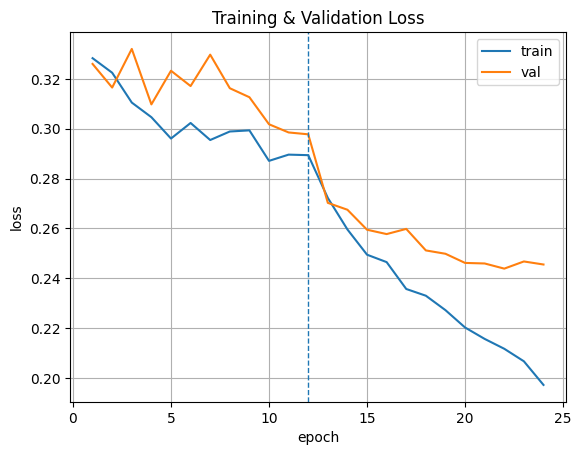

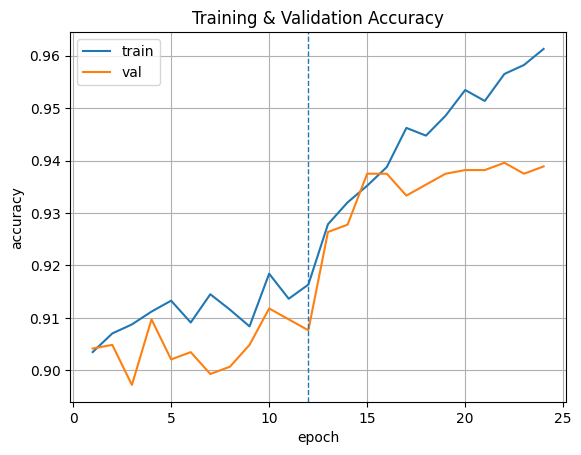

In [24]:
# === CELL: Plot Loss & Accuracy (train/val) ===
import matplotlib.pyplot as plt

def merge_histories(hist_list):
    """Concatenate multiple Keras History.history dicts."""
    merged = {}
    for h in hist_list:
        for k, v in h.items():
            merged.setdefault(k, []).extend(list(v))
    return merged

def find_key(d, candidates):
    """Return first existing key from candidates or None."""
    for k in candidates:
        if k in d:
            return k
    return None

# Collect available histories from globals
hist_dicts = []
phase_lengths = []
for name in ("history_p1", "history_p2", "history"):
    obj = globals().get(name, None)
    if obj is not None and hasattr(obj, "history"):
        hist_dicts.append(obj.history)
        # length of this phase for optional vertical separator
        phase_lengths.append(len(next(iter(obj.history.values()))))

if not hist_dicts:
    raise RuntimeError("No History found. Expected variables: history, history_p1, history_p2.")

hist = merge_histories(hist_dicts)

# Resolve keys across TF/Keras versions
loss_key     = find_key(hist, ["loss"])
val_loss_key = find_key(hist, ["val_loss"])
acc_key      = find_key(hist, ["accuracy", "acc"])
val_acc_key  = find_key(hist, ["val_accuracy", "val_acc"])

epochs = range(1, len(hist[loss_key]) + 1)

# ---- Plot Loss ----
plt.figure()
plt.plot(epochs, hist[loss_key], label="train")
if val_loss_key: 
    plt.plot(epochs, hist[val_loss_key], label="val")
# Optional separator between Phase 1 and Phase 2 (if both exist)
if len(phase_lengths) >= 2:
    plt.axvline(x=phase_lengths[0], linestyle="--", linewidth=1)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# ---- Plot Accuracy ----
if acc_key:
    plt.figure()
    plt.plot(epochs, hist[acc_key], label="train")
    if val_acc_key:
        plt.plot(epochs, hist[val_acc_key], label="val")
    if len(phase_lengths) >= 2:
        plt.axvline(x=phase_lengths[0], linestyle="--", linewidth=1)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No accuracy metric found in History (keys: ", list(hist.keys()), ")")


In [14]:
# === CELL 7: Validation & Test evaluation ===
def y_true_prob(ds, mdl):
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds.unbatch()])
    y_prob = mdl.predict(ds, verbose=0).ravel()
    return y_true, y_prob

# Val
vy_true, vy_prob = y_true_prob(val_ds, model)
v_auc = roc_auc_score(vy_true, vy_prob)
vfpr, vtpr, vthr = roc_curve(vy_true, vy_prob)
best_idx = np.argmax(vtpr - vfpr)
best_thr = vthr[best_idx]
v_pred = (vy_prob >= best_thr).astype(int)

print(f"[VAL]  AUC: {v_auc:.4f}, best thr: {best_thr:.3f}")
print(classification_report(vy_true, v_pred, target_names=class_names))
print("Val CM:\n", confusion_matrix(vy_true, v_pred))

# Test (håll-out)
ty_true, ty_prob = y_true_prob(test_ds, model)
t_auc = roc_auc_score(ty_true, ty_prob)
t_pred = (ty_prob >= best_thr).astype(int)  # använd val-optimal tröskel
print(f"\n[TEST] AUC: {t_auc:.4f} (thr från val: {best_thr:.3f})")
print(classification_report(ty_true, t_pred, target_names=class_names))
print("Test CM:\n", confusion_matrix(ty_true, t_pred))


[VAL]  AUC: 0.9850, best thr: 0.480
              precision    recall  f1-score   support

      benign       0.93      0.96      0.94       743
   malignant       0.95      0.92      0.94       697

    accuracy                           0.94      1440
   macro avg       0.94      0.94      0.94      1440
weighted avg       0.94      0.94      0.94      1440

Val CM:
 [[712  31]
 [ 53 644]]

[TEST] AUC: 0.9768 (thr från val: 0.480)
              precision    recall  f1-score   support

      benign       0.89      0.96      0.92       500
   malignant       0.96      0.88      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000

Test CM:
 [[481  19]
 [ 61 439]]


In [17]:
# === CELL 8: Save final model (weights + SavedModel, no JSON) ===
import os, glob, shutil, tensorflow as tf

ckpt_dir = EXPORT_DIR if 'EXPORT_DIR' in globals() else "."

# Prefer finetune weights (p2), fallback to phase 1
candidates = [
    os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p2.weights.h5"),
    os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1.weights.h5"),
    os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p2_weights.h5"),
    os.path.join(ckpt_dir, "transfer_efficientNetB3_best_p1_weights.h5"),
]
best_w = next((p for p in candidates if os.path.exists(p)), None)
if best_w is None:
    matches = glob.glob(os.path.join(ckpt_dir, "transfer_efficientNetB3*weights*.h5"))
    if not matches:
        raise FileNotFoundError(f"No weights file found in {ckpt_dir}")
    matches.sort()
    best_w = matches[-1]

# Load best weights into current `model`
model.load_weights(best_w)

# Save a weights snapshot (handy for quick reload)
final_weights = os.path.join(ckpt_dir, "transfer_efficientNetB3_finetuned.weights.h5")
model.save_weights(final_weights)

# Export as SavedModel (robust, no JSON serialization)
saved_dir = os.path.join(ckpt_dir, "transfer_efficientNetB3_finetuned_savedmodel")
if os.path.isdir(saved_dir):
    shutil.rmtree(saved_dir)

try:
    model.export(saved_dir)          # Keras 3
except Exception:
    tf.saved_model.save(model, saved_dir)  # TF-keras fallback

print("✅ Loaded weights from:", best_w)
print("✅ Saved weights snapshot to:", final_weights)
print("✅ Exported SavedModel to:", saved_dir)


INFO:tensorflow:Assets written to: exported_models\transfer_efficientNetB3_finetuned_savedmodel\assets


INFO:tensorflow:Assets written to: exported_models\transfer_efficientNetB3_finetuned_savedmodel\assets


✅ Loaded weights from: exported_models\transfer_efficientNetB3_best_p2.weights.h5
✅ Saved weights snapshot to: exported_models\transfer_efficientNetB3_finetuned.weights.h5
✅ Exported SavedModel to: exported_models\transfer_efficientNetB3_finetuned_savedmodel


              precision    recall  f1-score   support

      benign       0.89      0.96      0.92       500
   malignant       0.96      0.88      0.92       500

    accuracy                           0.92      1000
   macro avg       0.92      0.92      0.92      1000
weighted avg       0.92      0.92      0.92      1000



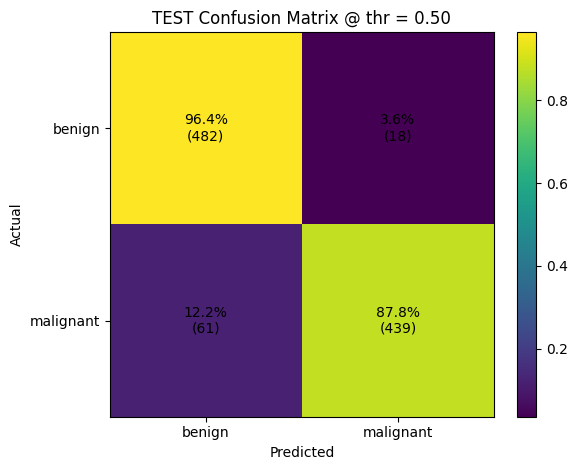

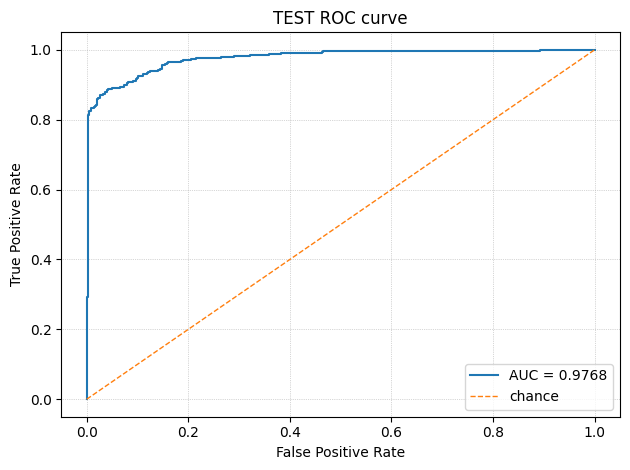

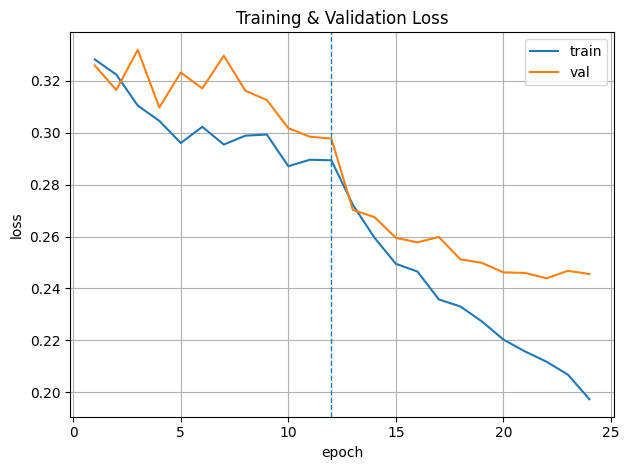

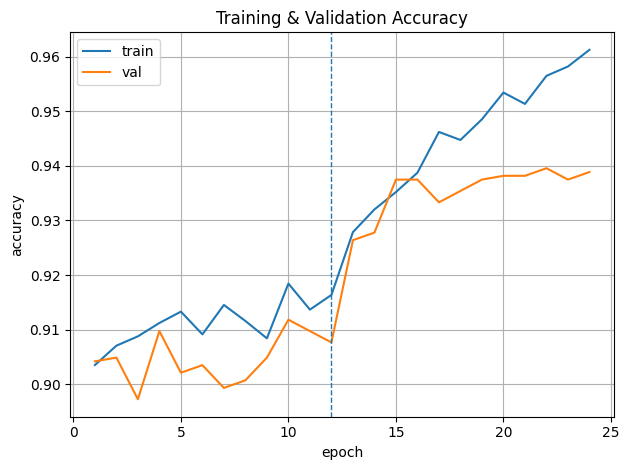

In [30]:
# === CELL: TEST (CM + ROC) + Train/Val Loss & Accuracy ===
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
# === METRICS: Classification report (TEST only) ===
import numpy as np
from sklearn.metrics import classification_report

def y_true_pred(ds, mdl, thr=0.50):
    """Return y_true and y_pred at a fixed probability threshold."""
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds.unbatch()]).astype(int)
    y_prob = mdl.predict(ds, verbose=0).ravel()
    y_pred = (y_prob >= float(thr)).astype(int)
    return y_true, y_pred

# Use TEST set, threshold = 0.50 (change if you want)
t_true, t_pred = y_true_pred(test_ds, model, thr=0.50)

print(classification_report(t_true, t_pred, target_names=class_names))


# ---------- TEST: collect labels & probabilities ----------
def get_y_true_prob(ds, mdl):
    y_true = np.concatenate([y.numpy().ravel() for _, y in ds.unbatch()])
    y_prob = mdl.predict(ds, verbose=0).ravel()
    return y_true.astype(int), y_prob

y_true, y_prob = get_y_true_prob(test_ds, model)
auc = roc_auc_score(y_true, y_prob)

# ---------- TEST: Confusion Matrix @ thr=0.50 ----------
thr = 0.50
y_pred = (y_prob >= thr).astype(int)
cm = confusion_matrix(y_true, y_pred)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure()
im = plt.imshow(cm_norm, interpolation="nearest")
plt.colorbar(im, fraction=0.046, pad=0.04)
xt = class_names if 'class_names' in globals() else ["0", "1"]
yt = class_names if 'class_names' in globals() else ["0", "1"]
plt.xticks([0,1], xt)
plt.yticks([0,1], yt)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"TEST Confusion Matrix @ thr = {thr:.2f}")
for i in range(2):
    for j in range(2):
        plt.text(j, i, f"{cm_norm[i,j]*100:.1f}%\n({cm[i,j]})", ha="center", va="center", fontsize=10)
plt.tight_layout()
plt.show()

# ---------- TEST: ROC curve ----------
fpr, tpr, _ = roc_curve(y_true, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", linewidth=1, label="chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TEST ROC curve")
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.5)
plt.tight_layout()
plt.show()

# ---------- TRAIN/VAL: Loss & Accuracy curves ----------
def merge_histories(hist_list):
    merged = {}
    for h in hist_list:
        for k, v in h.items():
            merged.setdefault(k, []).extend(list(v))
    return merged

def find_key(d, candidates):
    for k in candidates:
        if k in d:
            return k
    return None

# collect any available histories
hist_dicts, phase_lengths = [], []
for name in ("history_p1", "history_p2", "history"):
    obj = globals().get(name, None)
    if obj is not None and hasattr(obj, "history"):
        hist_dicts.append(obj.history)
        phase_lengths.append(len(next(iter(obj.history.values()))))

if hist_dicts:
    hist = merge_histories(hist_dicts)
    loss_key     = find_key(hist, ["loss"])
    val_loss_key = find_key(hist, ["val_loss"])
    acc_key      = find_key(hist, ["accuracy", "acc"])
    val_acc_key  = find_key(hist, ["val_accuracy", "val_acc"])
    epochs = range(1, len(hist[loss_key]) + 1)

    # Loss
    plt.figure()
    plt.plot(epochs, hist[loss_key], label="train")
    if val_loss_key: 
        plt.plot(epochs, hist[val_loss_key], label="val")
    if len(phase_lengths) >= 2:
        plt.axvline(x=phase_lengths[0], linestyle="--", linewidth=1)
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Training & Validation Loss")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

    # Accuracy
    if acc_key:
        plt.figure()
        plt.plot(epochs, hist[acc_key], label="train")
        if val_acc_key:
            plt.plot(epochs, hist[val_acc_key], label="val")
        if len(phase_lengths) >= 2:
            plt.axvline(x=phase_lengths[0], linestyle="--", linewidth=1)
        plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Training & Validation Accuracy")
        plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("No training history found; skipping loss/accuracy curves.")
